# Prediction of Used Car Prices
Our approach effectively combines deep learning and traditional machine learning techniques through transfer learning, enhancing the predictive power of your model by utilizing the strengths of both methodologies.



## Project Overview
This project aims to develop a machine learning model to predict the prices of used cars. The process involves several key steps:
1. **Data Loading**: We start by importing necessary libraries and mounting Google Drive to access the dataset.
2. **Data Preprocessing**: The data is then loaded, and initial preprocessing steps are carried out to prepare it for modeling. This includes parsing image paths and selecting relevant columns.
3. **Feature Extraction from Images**:
   - Using a pre-trained ResNet-34 model, we extract deep learning features from car images. These features are powerful representations of visual content within each image, capturing various attributes such as color, shape, and texture that might influence a car's price.
   - Each image is processed through the ResNet-34 network, which has been adjusted to exclude the final classification layer, allowing us to capture a rich feature set from the penultimate layer of the network.
   - The extracted features are stored as arrays for each image and then integrated into the main DataFrame. This involves transforming the list of feature arrays into a new DataFrame column, which is subsequently concatenated with the existing car data.
4. **Model Setup**:
   - We setup a RandomForestRegressor within a pipeline, optimized via GridSearchCV to find the best model parameters. This combination of deep learning features with traditional machine learning techniques allows for robust predictive modeling.
5. **Model Training and Evaluation**:
   - The model is trained on the preprocessed data, including the newly integrated image features.
   - Its performance is evaluated through various plots comparing predicted values against actual prices, helping visualize the model's effectiveness and any areas where it may be improved.

The following sections detail each step with code and explanations to ensure clarity and reproducibility of results.


# Setup and Imports
This section handles the necessary imports and sets up the environment.


In [13]:
import torch
import torch.nn as nn
from fastai.vision.models import resnet34, ResNet34_Weights
from fastai.vision.all import PILImage, tensor
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Mount Google Drive
Here we mount the Google Drive to access the dataset stored there.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading
Loading and initial preprocessing of the car dataset.

In [3]:
cars_data_directory = '/content/drive/My Drive/cars_dataset/'
cars_data_images = '/content/drive/My Drive/cars_photos/symbol/'
cars_data_file = Path(cars_data_directory) / 'CNN_symbol'
df = pd.read_csv(cars_data_file)
df['image_path'] = cars_data_images + df['filename']
df = df[['image_path', 'Brand', 'Model', 'Year', 'Mileage', 'Color', 'Body', 'Transmission', 'Engine', 'Fuel', 'price']]

# Pre-trained Model Setup
Loading the pre-trained ResNet-34 model and adjusting it for feature extraction.

In [ ]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

# Feature Extraction
Define and apply a function to extract image features using the modified ResNet-34 model.

In [5]:
def extract_features(img_path, model):
    img = PILImage.create(img_path)
    img = img.resize((224, 224))
    img_tensor = tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    with torch.no_grad():
        features = model(img_tensor).squeeze().numpy()
    return features

df['features'] = df['image_path'].apply(lambda x: extract_features(x, model))
features_df = pd.DataFrame(df['features'].tolist())
result_df = pd.concat([df, features_df], axis=1).drop(columns=['features'])
print(f"Feature array length: {len(df['features'].iloc[0])}")
result_df.head()

Feature array length: 512


,image_path,Brand,Model,Year,Mileage,Color,Body,Transmission,Engine,Fuel,...,502,503,504,505,506,507,508,509,510,511
0,/content/drive/My Drive/cars_photos/symbol/1.jpg,renault,symbol,2012,340,black,berline,manual,1.4,gasoline,...,0.885937,0.449068,14.872375,9.043772,0.395452,14.749463,0.0,1.359506,8.338740,45.881008
1,/content/drive/My Drive/cars_photos/symbol/2.jpg,renault,symbol,2018,180,grey,berline,manual,1.2,gasoline,...,1.379624,1.941020,24.896706,3.512604,0.511438,14.098274,0.0,0.275304,8.857440,42.777992
2,/content/drive/My Drive/cars_photos/symbol/3.jpg,renault,symbol,2018,100,grey,berline,manual,1.2,gasoline,...,0.568942,1.121916,26.577927,3.850368,0.238489,12.009172,0.0,3.316304,5.106100,25.951145
3,/content/drive/My Drive/cars_photos/symbol/4.jpg,renault,symbol,2018,100,grey,berline,manual,1.2,gasoline,...,1.877203,0.535122,34.277939,4.065197,0.455912,11.606194,0.0,0.176045,15.068775,26.144005
4,/content/drive/My Drive/cars_photos/symbol/5.jpg,renault,symbol,2018,100,grey,berline,manual,1.2,gasoline,...,1.271371,2.156049,19.325085,3.949862,0.486519,11.979256,0.0,0.724776,7.941953,30.984636


# Data Splitting
Splitting the dataset into training and testing subsets.

In [6]:
X = result_df.drop(columns=['image_path', 'Brand', 'Model', 'Year', 'Mileage', 'Color', 'Body', 'Transmission', 'Engine', 'Fuel', 'price'])
y = result_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
Setting up a pipeline and grid search for hyperparameter tuning and training the RandomForestRegressor.

In [9]:
param_grid = {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [None, 10, 20]}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, grid_search.predict(X_test)))}")
print(f"Best model parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Root Mean Squared Error: 32.25827413238346
Best model parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 100}


# Model Evaluation
Plotting predictions against actual prices to evaluate the model performance.

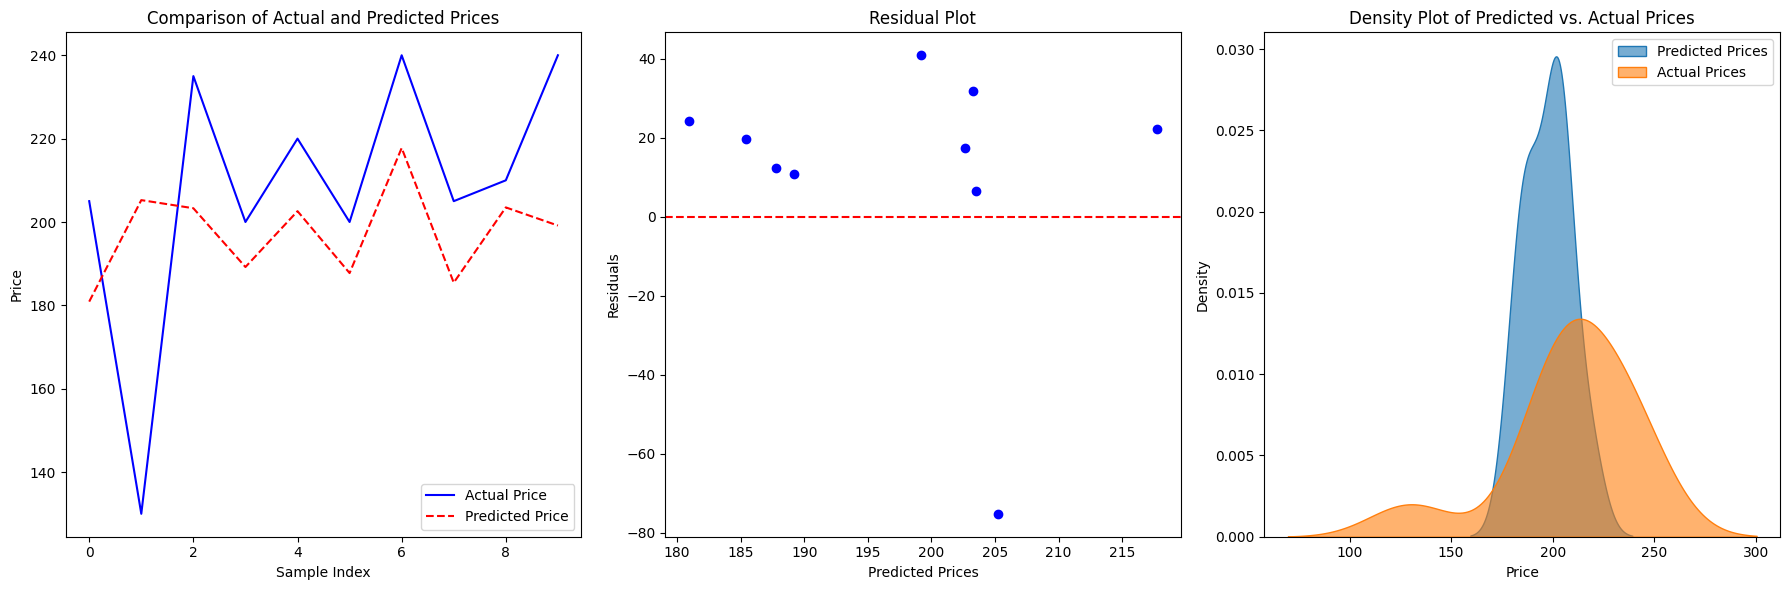

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the figure and define the subplot layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Comparison of Actual and Predicted Prices
axs[0].plot(y_test.reset_index(drop=True), label='Actual Price', color='blue')
axs[0].plot(grid_search.predict(X_test), label='Predicted Price', linestyle='--', color='red')
axs[0].set_title('Comparison of Actual and Predicted Prices')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot for Residual Plot
residuals = y_test - grid_search.predict(X_test)
axs[1].scatter(grid_search.predict(X_test), residuals, color='blue')
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title('Residual Plot')
axs[1].set_xlabel('Predicted Prices')
axs[1].set_ylabel('Residuals')

# Plot for Density Plot of Predicted vs. Actual Prices
sns.kdeplot(grid_search.predict(X_test), fill=True, label='Predicted Prices', alpha=0.6, ax=axs[2])
sns.kdeplot(y_test, fill=True, label='Actual Prices', alpha=0.6, ax=axs[2])
axs[2].set_title('Density Plot of Predicted vs. Actual Prices')
axs[2].set_xlabel('Price')
axs[2].legend()

# Display all plots
plt.tight_layout()
plt.show()
